In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.model_selection import train_test_split

# Load data

In [2]:
# File paths
image_dir = '../images'
labels_df = pd.read_csv('../labels.csv')

# Extract file names and labels
image_filenames = labels_df['Filename'].values
y = labels_df['Label'].values

# Construct full image paths
image_paths = [os.path.join(image_dir, fname) for fname in image_filenames]

# Ensure images and labels are aligned
if len(image_paths) != len(y):
    raise ValueError("Number of images and labels do not match.")

labels_df.head()

,Filename,Label,Species
0,20160928-140314-0.jpg,0,Chinee apple
1,20160928-140337-0.jpg,0,Chinee apple
2,20160928-140731-0.jpg,0,Chinee apple
3,20160928-140747-0.jpg,0,Chinee apple
4,20160928-141107-0.jpg,0,Chinee apple


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Dealing with imbalance data

To mitigate class imbalance, I will randomly select Negative instances (Label is 8) to balance with other classes.

In [4]:
# Calculate the average number of rows for labels 0 to 7
filtered_df = labels_df[labels_df['Label'].between(0, 7)]
label_counts = filtered_df['Label'].value_counts()
average_count = int(label_counts.mean())  # Convert to integer for sampling

# Filter rows with label 8
negative_df = labels_df[labels_df['Label'] == 8]

# Randomly select `average_count` rows from label 8
selected_negative = negative_df.sample(n=average_count, random_state=42)

# Combine the selected label 8 rows with the rest of the data (excluding extra label 8 rows)
labels_df = pd.concat([filtered_df, selected_negative])

# Extract file names and labels
image_filenames = labels_df['Filename'].values
y = labels_df['Label'].values

# Construct full image paths
image_paths = [os.path.join(image_dir, fname) for fname in image_filenames]

# Ensure images and labels are aligned
if len(image_paths) != len(y):
    raise ValueError("Number of images and labels do not match.")

In [5]:
# Check the distribution after balancing the dataset

pair_count = labels_df.groupby(['Label', 'Species']).size().reset_index(name='Count')
pair_count_sorted = pair_count.sort_values(by='Label')

print(pair_count_sorted.to_string(index=False))


 Label        Species  Count
     0   Chinee apple   1125
     1        Lantana   1064
     2    Parkinsonia   1031
     3     Parthenium   1022
     4 Prickly acacia   1062
     5    Rubber vine   1009
     6      Siam weed   1074
     7     Snake weed   1016
     8       Negative   1050


# Train test split

I didn't split train data into train and validation dataset to utilize cross validation later when training models.

In [6]:
# Split into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(image_paths, y, test_size=0.2, stratify=y, random_state=42)

# Create label-to-species mapping for displaying label counts
label_to_species = dict(zip(labels_df['Label'], labels_df['Species']))

# Label distribution
def print_label_distribution(y_train, y_test, label_to_species):
    # Create label counts for train and test datasets
    train_label_counts = pd.Series(y_train).value_counts().reset_index()
    test_label_counts = pd.Series(y_test).value_counts().reset_index()

    # Rename columns
    train_label_counts.columns = ['Label', 'Count']
    test_label_counts.columns = ['Label', 'Count']

    # Map species to the label counts
    train_label_counts['Species'] = train_label_counts['Label'].map(label_to_species)
    test_label_counts['Species'] = test_label_counts['Label'].map(label_to_species)

    # Display the distributions
    print("Training dataset distribution:")
    print(train_label_counts.to_string(index=False))

    print("\nTesting dataset distribution:")
    print(test_label_counts.to_string(index=False))

print_label_distribution(y_train, y_test, label_to_species)

Training dataset distribution:
 Label  Count        Species
     0    900   Chinee apple
     6    859      Siam weed
     1    851        Lantana
     4    849 Prickly acacia
     8    840       Negative
     2    825    Parkinsonia
     3    818     Parthenium
     7    813     Snake weed
     5    807    Rubber vine

Testing dataset distribution:
 Label  Count        Species
     0    225   Chinee apple
     6    215      Siam weed
     4    213 Prickly acacia
     1    213        Lantana
     8    210       Negative
     2    206    Parkinsonia
     3    204     Parthenium
     7    203     Snake weed
     5    202    Rubber vine


# Pre-processing (resizing, normalization, edge detection)

In [7]:
import tensorflow as tf
import numpy as np
import cv2  # For edge detection

# Function to load and decode images
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)  # Decode as RGB image
    return image

# Preprocess image: resize and normalize
def preprocess_image(image, target_size=(224, 224)):
    image = tf.image.resize(image, target_size)  # Resize image to the target size
    image = image / 255.0  # Normalize to [0, 1]
    return image

# Edge detection using Canny or Sobel
def edge_detection(image):
    # Convert Tensor to NumPy array for edge detection
    image = image.numpy()  # Convert image to NumPy array
    
    # Convert the image to uint8 (necessary for Canny edge detection)
    image = (image * 255).astype(np.uint8)  # Scale back to [0, 255] and cast to uint8
    
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)  # Convert to grayscale
    edges = cv2.Canny(gray_image, threshold1=100, threshold2=200)  # Apply Canny edge detection
    edges = np.expand_dims(edges, axis=-1)  # Add channel dimension back to make it 3D (HxWx1)
    edges = np.repeat(edges, 3, axis=-1)  # Repeat the edge detection result across all 3 channels (RGB)
    return edges

# Create the dataset for training and testing
def create_dataset(image_paths, labels, batch_size=32, augment=False):
    X_processed = []
    y_processed = []

    for image_path, label in zip(image_paths, labels):
        # Load and preprocess the image
        image = load_image(image_path)
        image = preprocess_image(image)
        
        # Apply edge detection
        image_with_edges = tf.py_function(edge_detection, [image], tf.float32)
        
        # Append processed image and label
        X_processed.append(image_with_edges)
        y_processed.append(label)

    # Convert lists to NumPy arrays for further use
    X_processed = np.array(X_processed)
    y_processed = np.array(y_processed)

    return X_processed, y_processed

X_train_processed, y_train_processed = create_dataset(X_train, y_train)
X_test_processed, y_test_processed = create_dataset(X_test, y_test)


# Feature Extraction

### Feature extraction functions

In [8]:
import tensorflow as tf
import numpy as np
import cv2
from skimage.feature import local_binary_pattern

# Calculate the mean RGB values  
def mean_rgb_array(image):
    return np.mean(image, axis=(0, 1))  # Mean along height and width

# Compute Local Binary Pattern (LBP) features 
def lbp_features(image, radius=1, n_points=8):
    # Convert to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # Compute LBP
    lbp = local_binary_pattern(gray_image, n_points, radius, method="uniform")
    
    # Return the histogram of LBP
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-7)  # Normalize histogram
    return np.mean(hist) # mean of the LBP histogram 

# Compute the mean value of the Laplacian 
def laplacian_mean_value(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    laplacian = cv2.Laplacian(gray_image, cv2.CV_64F)
    return np.mean(np.abs(laplacian))  # Return mean of absolute Laplacian values

# Compute the mean value of edges in an image using Canny edge detection 
def edge_mean_value(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray_image, threshold1=100, threshold2=200)
    return np.mean(edges)  # Mean edge intensity

# Compute the mean value of Harris corner strengths 
def corner_mean_value(image, block_size=2, ksize=3, k=0.04):
    """
    Parameters:
    - block_size: The size of the neighborhood considered for corner detection.
    - ksize: Aperture parameter of the Sobel derivative used.
    - k: Harris detector free parameter in the equation.
    """
    # Convert to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    gray_image = np.float32(gray_image)  # Convert to float32 for cornerHarris

    # Apply Harris corner detection
    corners = cv2.cornerHarris(gray_image, block_size, ksize, k)
    
    # Normalize the corner response to the range [0, 1]
    corners_normalized = cv2.normalize(corners, None, 0, 1, norm_type=cv2.NORM_MINMAX)
    
    # Calculate the mean value of corner strengths
    mean_corner_strength = np.mean(corners_normalized)
    
    return mean_corner_strength

### Apply Feature Extraction Functions

In [9]:
# Extract features for a single image
def extract_features(image):
    # Convert Tensor to NumPy array for processing
    image_np = image.numpy()
    image_np = (image_np * 255).astype(np.uint8)  # Scale to [0, 255]
    
    # Extract features
    features = {
        "rgb_mean": mean_rgb_array(image_np),  # Mean RGB values
        "lbp_mean": lbp_features(image_np),  # Local Binary Pattern histogram
        "laplacian_mean": laplacian_mean_value(image_np),  # Mean Laplacian value
        "edge_mean": edge_mean_value(image_np),  # Mean edge intensity
        "corner_mean": corner_mean_value(image_np),  # Mean corner strength
    }
    return features

# Final Feature Extraction
def extract_features_from_dataset(image_paths):
    feature_list = []
    for image_path in image_paths:
        # Load and preprocess the image
        image = load_image(image_path)
        image = preprocess_image(image)
        
        # Extract features
        features = extract_features(image)
        feature_list.append(features)
    
    return feature_list

### Feature Extraction on Training Data 

In [10]:
train_extracted_features = np.array(extract_features_from_dataset(X_train))
print(train_extracted_features)

[{'rgb_mean': array([78.0228396 , 79.32079082, 77.62215003]), 'lbp_mean': np.float64(0.0999999999998007), 'laplacian_mean': np.float64(94.46012037627551), 'edge_mean': np.float64(82.7164381377551), 'corner_mean': np.float32(0.28835854)}
 {'rgb_mean': array([93.94533243, 90.40156649, 82.38813377]), 'lbp_mean': np.float64(0.09999999999980069), 'laplacian_mean': np.float64(37.626395089285715), 'edge_mean': np.float64(61.70699139030612), 'corner_mean': np.float32(0.36601585)}
 {'rgb_mean': array([77.92165577, 90.9279536 , 84.08725287]), 'lbp_mean': np.float64(0.09999999999980069), 'laplacian_mean': np.float64(85.49447943239795), 'edge_mean': np.float64(91.84390943877551), 'corner_mean': np.float32(0.19910921)}
 ...
 {'rgb_mean': array([86.73427535, 93.06580835, 81.62820871]), 'lbp_mean': np.float64(0.0999999999998007), 'laplacian_mean': np.float64(68.41095344387755), 'edge_mean': np.float64(86.4111328125), 'corner_mean': np.float32(0.41705394)}
 {'rgb_mean': array([99.25117586, 79.62017698

In [11]:
# Flatten the image data
X_train_flattened = X_train_processed.reshape(X_train_processed.shape[0], -1)

In [12]:
train_features_list = []
for feature in train_extracted_features:
    rgb_mean = feature['rgb_mean']
    lbp_mean = feature['lbp_mean']
    laplacian_mean = feature['laplacian_mean']
    edge_mean = feature['edge_mean']
    corner_mean = feature['corner_mean']
    
    # Flatten the mean_rgb array and concatenate other features into a single list
    features = np.concatenate([rgb_mean, 
                               [lbp_mean, laplacian_mean, edge_mean, corner_mean]])
    train_features_list.append(features)

# Convert the list of features into a numpy array
train_extracted_features_array = np.array(train_features_list)

# Concatenate the image data with the extracted features
X_train_final = np.concatenate([X_train_flattened, train_extracted_features_array], axis=1)
y_train_final = y_train_processed

#### Feature Extraction on Testing Data

In [13]:
test_extracted_features = np.array(extract_features_from_dataset(X_test))

X_test_flattened = X_test_processed.reshape(X_test_processed.shape[0], -1)

test_features_list = []
for feature in test_extracted_features:
    rgb_mean = feature['rgb_mean']
    lbp_mean = feature['lbp_mean']
    laplacian_mean = feature['laplacian_mean']
    edge_mean = feature['edge_mean']
    corner_mean = feature['corner_mean']
    
    # Flatten the mean_rgb array and concatenate other features into a single list
    features = np.concatenate([rgb_mean, 
                               [lbp_mean, laplacian_mean, edge_mean, corner_mean]])
    test_features_list.append(features)

# Convert the list of features into a numpy array
test_extracted_features_array = np.array(test_features_list)

# Concatenate the image data with the extracted features
X_test_final = np.concatenate([X_test_flattened, test_extracted_features_array], axis=1)
y_test_final = y_test_processed

### PCA

In [14]:
from sklearn.decomposition import PCA

apply_PCA = True

if apply_PCA:
    print(f'Original number of features: {X_train_final.shape[1]}')

    pca = PCA(n_components=64, random_state=42)
    X_train_final = pca.fit_transform(X_train_final)
    X_test_final = pca.transform(X_test_final)

    print(f'Reduced number of features after PCA: {X_train_final.shape[1]}')

Original number of features: 150535
Reduced number of features after PCA: 64


### LDA

In [15]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

apply_LDA = True

if apply_LDA:
    print(f'Original number of features: {X_train_final.shape[1]}')

    lda = LinearDiscriminantAnalysis(n_components=8)
    X_train_final = lda.fit_transform(X_train_final, y_train_final)
    X_test_final = lda.transform(X_test_final)

    print(f'Reduced number of features after LDA: {X_train_final.shape[1]}')

Original number of features: 64
Reduced number of features after LDA: 8


### SVM

A Support Vector Machine (SVM) is a supervised machine learning algorithm widely used for classification and regression tasks. SVMs are particularly effective in high-dimensional spaces and for problems where the decision boundary between classes is complex.

### Classification Report

In [16]:
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt


# Make svm prediction
from sklearn import svm
svc_rbf = svm.SVC(kernel='rbf', gamma="scale")
svc_rbf.fit(X_train_final, y_train_final)
y_pred_svm = svc_rbf.predict(X_test_final)

# Evaluate using macro-averaged precision, recall, and F1 score
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_svm, average='macro')

# Define the label mapping
target_names = ['Chinese Apple', 'Lantana', 'Parkinsonia', 'Parthenium', 
                'Prickly acacia', 'Rubber vine', 'Siam weed', 'Snake Weed', 'Negatives']

# Output the evaluation metrics
print(f"Macro-averaged Precision: {precision:.2f}")
print(f"Macro-averaged Recall: {recall:.2f}")
print(f"Macro-averaged F1 score: {f1:.2f}")

# Classification Report
print("Classification Report for SVM:")
print(classification_report(y_test,y_pred_svm,target_names=target_names))

Macro-averaged Precision: 0.29
Macro-averaged Recall: 0.29
Macro-averaged F1 score: 0.26
Classification Report for SVM:
                precision    recall  f1-score   support

 Chinese Apple       0.33      0.30      0.31       225
       Lantana       0.21      0.16      0.18       213
   Parkinsonia       0.34      0.71      0.46       206
    Parthenium       0.28      0.13      0.18       204
Prickly acacia       0.36      0.07      0.12       213
   Rubber vine       0.25      0.50      0.33       202
     Siam weed       0.31      0.30      0.30       215
    Snake Weed       0.29      0.16      0.21       203
     Negatives       0.23      0.23      0.23       210

      accuracy                           0.28      1891
     macro avg       0.29      0.29      0.26      1891
  weighted avg       0.29      0.28      0.26      1891



### Confusion Matrix

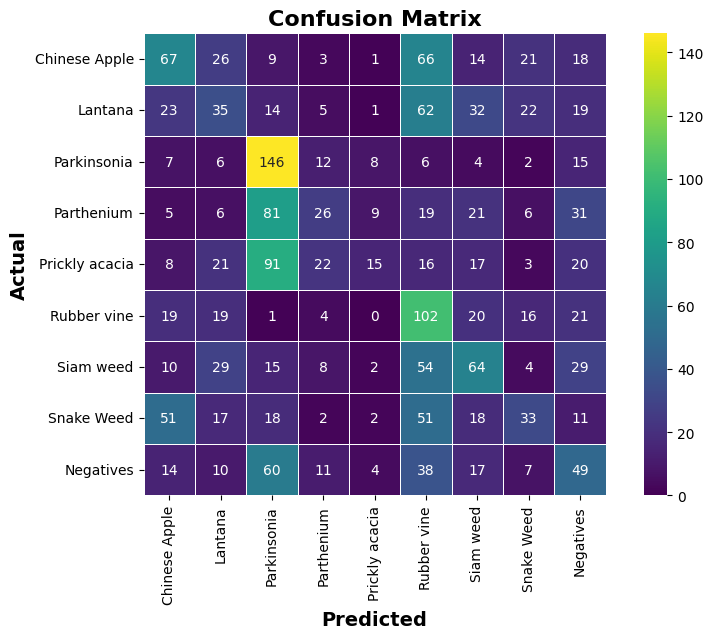


Confusion Matrix:
 [[ 67  26   9   3   1  66  14  21  18]
 [ 23  35  14   5   1  62  32  22  19]
 [  7   6 146  12   8   6   4   2  15]
 [  5   6  81  26   9  19  21   6  31]
 [  8  21  91  22  15  16  17   3  20]
 [ 19  19   1   4   0 102  20  16  21]
 [ 10  29  15   8   2  54  64   4  29]
 [ 51  17  18   2   2  51  18  33  11]
 [ 14  10  60  11   4  38  17   7  49]]


In [18]:
# Generate and print the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_svm)

plt.figure(figsize=(10, 6))

sns.heatmap(
    conf_matrix, annot=True, fmt='d', cmap='viridis', linewidths=0.4, square=True, cbar=True,
    xticklabels=['Chinese Apple', 'Lantana', 'Parkinsonia', 'Parthenium', 
                'Prickly acacia', 'Rubber vine', 'Siam weed', 'Snake Weed', 'Negatives'],
    yticklabels=['Chinese Apple', 'Lantana', 'Parkinsonia', 'Parthenium', 
                'Prickly acacia', 'Rubber vine', 'Siam weed', 'Snake Weed', 'Negatives']
)

plt.xlabel('Predicted', fontsize=14, fontweight='bold')
plt.ylabel('Actual', fontsize=14, fontweight='bold')
plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.yticks(rotation=360)

plt.show()
print("\nConfusion Matrix:\n", conf_matrix)